In [1]:
import harp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely import to_wkt
import shapely as shp

import time
import os

In [2]:
#full orbits
filename = "Sentinel-5P/TROPOMI/L2__NO2___/2019/06/14/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc"
path = "../S3/"
filename = path+filename
product = harp.import_product(filename)
spatial_extent = [19.5, 31.5, 29.5, 34.5] # mediterranean sea area

The resulting `product` python variable is just a record containing the product variables with numpy arrays for the data. You can inspect the contents using the Python `print()` function:

In [3]:
print(product)

source product = 'S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc'

int scan_subindex {time=1460700}
double datetime_start {time=1460700} [seconds since 2010-01-01]
float datetime_length [s]
long orbit_index
long validity {time=1460700}
float latitude {time=1460700} [degree_north]
float longitude {time=1460700} [degree_east]
float latitude_bounds {time=1460700, 4} [degree_north]
float longitude_bounds {time=1460700, 4} [degree_east]
float sensor_latitude {time=1460700} [degree_north]
float sensor_longitude {time=1460700} [degree_east]
float sensor_altitude {time=1460700} [m]
float solar_zenith_angle {time=1460700} [degree]
float solar_azimuth_angle {time=1460700} [degree]
float sensor_zenith_angle {time=1460700} [degree]
float sensor_azimuth_angle {time=1460700} [degree]
double pressure_bounds {time=1460700, vertical=34, 2} [Pa]
float tropospheric_NO2_column_number_density {time=1460700} [mol/m^2]
float tropospheric_NO2_column_number_density_uncer

It is important to realise that the `harp.import_product` function does not return the data in the same structure as it can be found in the netcdf file (and how you might get it with libraries such as `netCDF4` or `xarray`). HARP really performs an _import_ and converts the data from the original Sentinel-5P L2 format to a structure that is compatible with the HARP conventions.

This conversion mainly consists of renaming of variables, restructuring the dimensions, and leaving out the 'less important' variables. HARP has builtin converters for [a lot of atmospheric data products](http://stcorp.github.io/harp/doc/html/ingestions/index.html). For each conversion the HARP documentation contains a description of the variables it will return and how it mapped them from the original product format. The description for the product that we ingested can be found in the [S5P_L2_NO2](http://stcorp.github.io/harp/doc/html/ingestions/S5P_L2_NO2.html) description.

HARP does this conversion such that data from other satellite data products, such as OMI, or GOME-2, will end up having the same structure and naming conventions. This makes it a lot easier for users such as yourself to deal with data coming from different satellite missions.

To visualise the L2 data we will be using [cartopy](https://scitools.org.uk/cartopy/docs/latest/).

Unfortunately, there is no ideal plot function in cartopy to show the L2 data. The main choices are the `scatter`, `pcolormesh`, and `contourf` functions. For larger datasets the `contourf` function becomes very slow and the `pcolormesh` is then often a better approach. We will thus only look at the `scatter` and `pcolormesh` functions.

_Note that none of the cartopy functions can properly deal with the corner coordinates that are provided by the `latitude_bounds` and `longitude_bounds` variables. All of them deal with center coordinates only (using the `latitude` and `longitude` variables). If you want to have plots of L2 data that uses the actual corner coordinates then you will have to use VISAN._

Below, we will define two functions that will allow us to plot variables of an imported HARP product with cartopy. One will create a scatter plot (`scatter`), and the other a mesh plot (`pcolormesh`).

You don't have to understand this code for now, so just execute the code blocks and move on below to where we call the functions to create the actual plots.

In [4]:
def harp_l2geoscatterplot(product, value, colorrange=None, colortable='jet'):
    variable = product[value]
    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.scatter(product.longitude.data, product.latitude.data, c=variable.data, 
                      vmin=vmin, vmax=vmax, cmap=colortable, s=1, transform=ccrs.PlateCarree())

    ax.coastlines()
    # ax.set_extent(spatial_extent)

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()

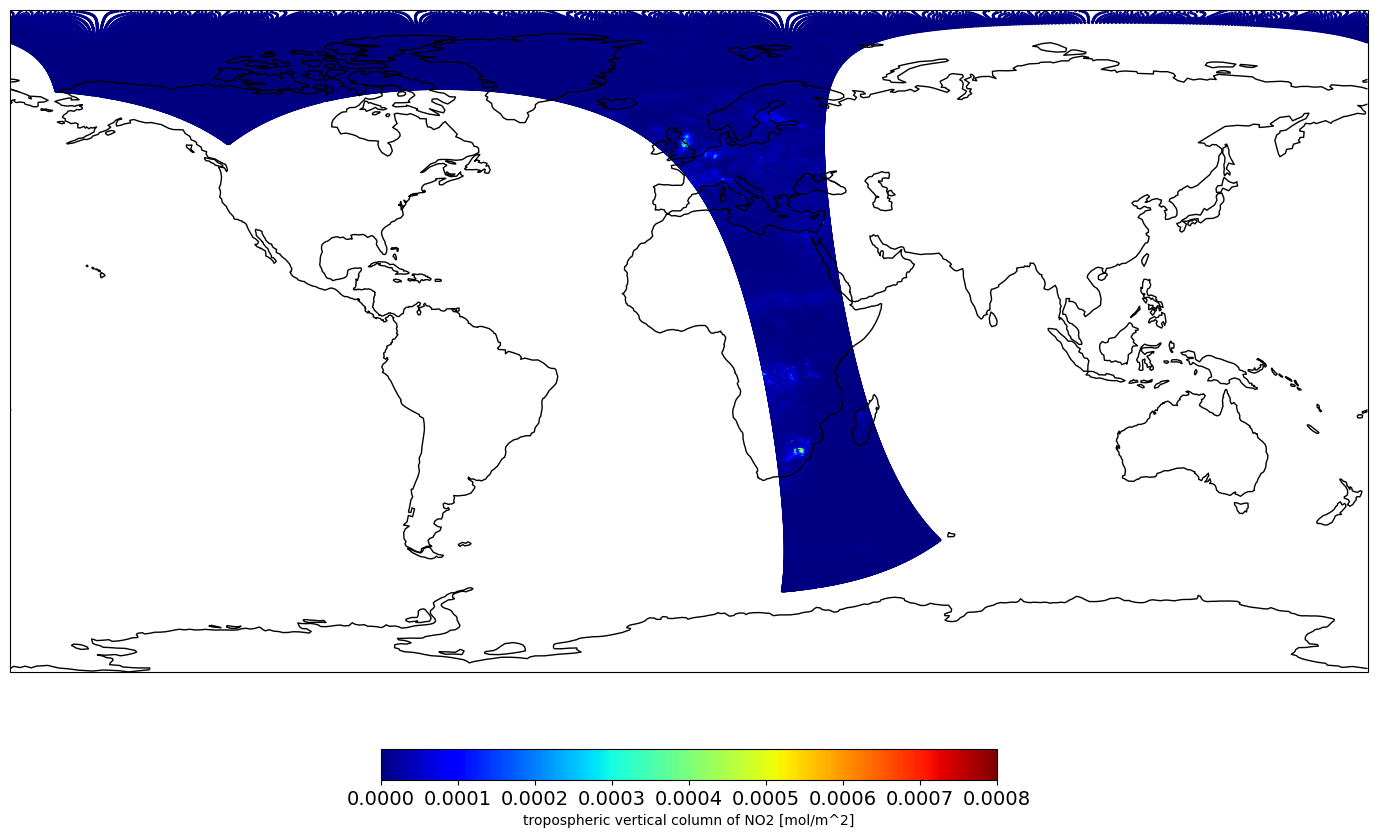

In [5]:
harp_l2geoscatterplot(product, 'tropospheric_NO2_column_number_density', colorrange=(0,0.0008))

One of the main features of HARP is the ability to perform operations as part of the data import.
Below we will add three different operations as part of the import:
- we only ingest data that is between 50 and 55 degrees latitude
- we only ingest data where the validity is good enough (this is the `qa_value>0.5` filter that is mentioned in the [Product Readme File for NO2](https://sentinels.copernicus.eu/documents/247904/3541451/Sentinel-5P-Nitrogen-Dioxide-Level-2-Product-Readme-File); the PRFs for all S5P products can be found on the offical [S5P documentation page](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-5p/products-algorithms))
- we limit the variables that we read to those that we want
- we convert the unit of the tropospheric NO2 column number density to Pmolec/cm2 (instead of using mol/m2 in which that data was stored)

All these operations will be performed by HARP, in sequence, while the data is being read, and before it is returned to us in Python. Since the operations are performed by HARP, which is written in C, it is often much faster to let those operations be performed by HARP than trying to post-process the data yourself in Python.

Information on all operations that can be passed this way can be found in the [HARP operations documentation](http://stcorp.github.io/harp/doc/html/operations.html).

In [6]:
operations = ";".join([
    f"latitude>{spatial_extent[1]};latitude<{spatial_extent[3]}",
    f"longitude>{spatial_extent[0]};longitude<{spatial_extent[2]}",
    "cloud_fraction< 0.5",
    "tropospheric_NO2_column_number_density_validity>20",
    "keep(datetime_start,scan_subindex,latitude,longitude,tropospheric_NO2_column_number_density, solar_zenith_angle)",
    # "derive(solar_zenith_angle [degrees])",
])
print(f"operations=\"{operations}\"")
print(f"filename=\"{filename}\"")
reduced_product = harp.import_product(filename, operations=operations)

operations="latitude>31.5;latitude<34.5;longitude>19.5;longitude<29.5;cloud_fraction< 0.5;tropospheric_NO2_column_number_density_validity>20;keep(datetime_start,scan_subindex,latitude,longitude,tropospheric_NO2_column_number_density, solar_zenith_angle)"
filename="../S3/Sentinel-5P/TROPOMI/L2__NO2___/2019/06/14/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc"


You will see that importing the data now goes a _lot_ faster. And if we print the contents of the `product` variable we see exactly the data that we requested:

In [7]:
print(reduced_product)

source product = 'S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc'
history = "2024-02-14T09:50:26Z [harp-1.20.2] harp.import_product('../S3/Sentinel-5P/TROPOMI/L2__NO2___/2019/06/14/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc',operations='latitude>31.5;latitude<34.5;longitude>19.5;longitude<29.5;cloud_fraction< 0.5;tropospheric_NO2_column_number_density_validity>20;keep(datetime_start,scan_subindex,latitude,longitude,tropospheric_NO2_column_number_density, solar_zenith_angle)')"

int scan_subindex {time=10499}
double datetime_start {time=10499} [seconds since 2010-01-01]
float latitude {time=10499} [degree_north]
float longitude {time=10499} [degree_east]
float solar_zenith_angle {time=10499} [degree]
float tropospheric_NO2_column_number_density {time=10499} [mol/m^2]



If we now create a scatter plot we get:

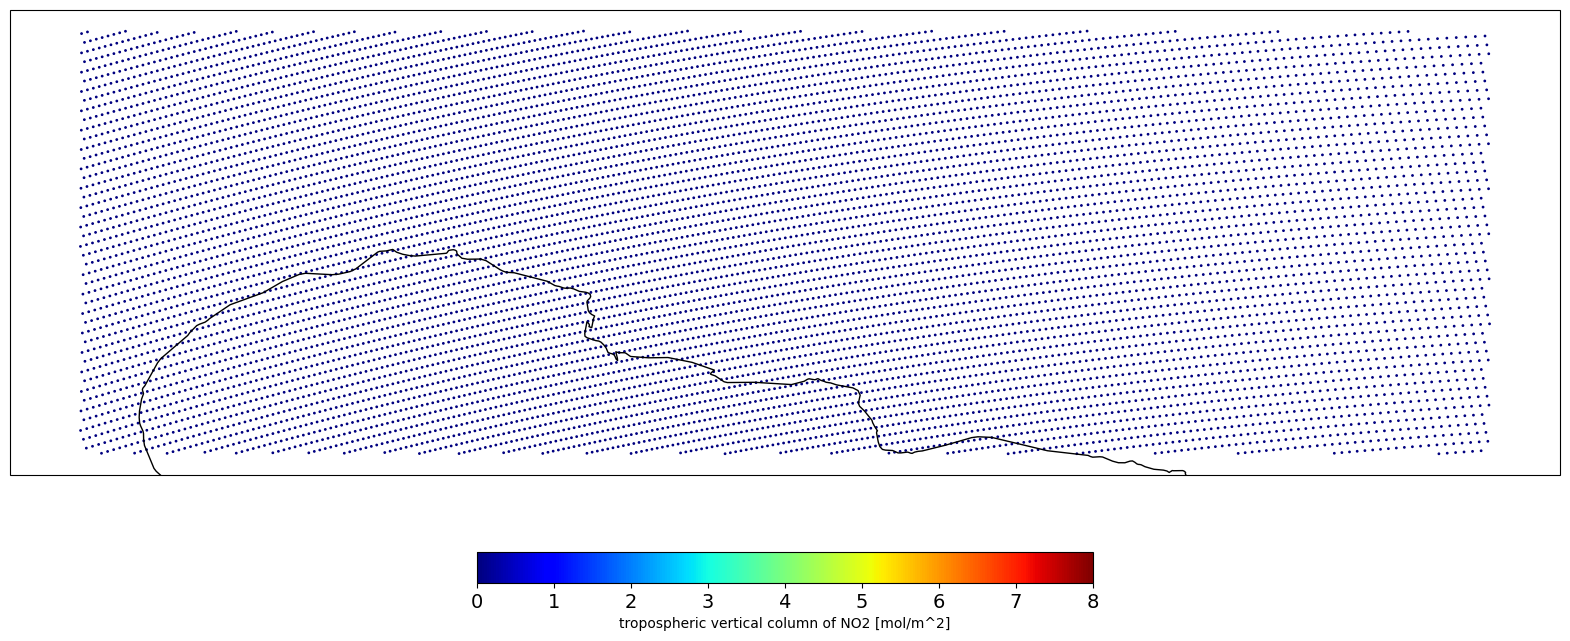

In [8]:
harp_l2geoscatterplot(reduced_product, 'tropospheric_NO2_column_number_density', colorrange=(0,8))

![s5p-no2-20200915](./s5p-no2-20200915.png)

We can perform this regridding by using the bin_spatial() operation of HARP. The bin_spatial() operation takes 6 parameters:

    the number of latitude edge points
    the latitude offset at which to start the grid
    the latitude increment (= latitude length of a grid cell)
    the number of longitude edge points
    the longitude offset at which to start the grid
    the longitude increment (= longitude length of a grid cell)

Note that the number edge points is one more than the number of grid cells. This is similar to the way you should provide the X and Y parameters to the pcolormesh function (see matplotlib documentation).

So, if we want to have a 0.1 degree by 0.1 degree global grid, we will need 1800 by 3600 grid cells (which equals 1801 by 3601 grid edge points).

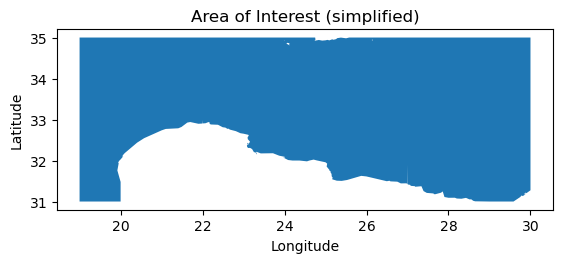

In [112]:
# load geometry from file
gdf = gpd.read_file('../../Data/Shapefiles/water-polygons-split-4326/water_polygons.shp', 
                    bbox=spatial_extent, CRS=ccrs.PlateCarree())

polygons = gdf['geometry'].tolist()
polygon = MultiPolygon(polygons).simplify(0.01, preserve_topology=False)

# plot simplified multipolygon
gdf_simple = gpd.GeoDataFrame({'geometry': [polygon]})
gdf_simple.plot()
plt.title('Area of Interest (simplified)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


`lat_resolution = lon_resolution = 0.003  # takes 18 seconds`

`lat_resolution = lon_resolution = 0.004  # takes 6 seconds`

`lat_resolution = lon_resolution = 0.005  # takes 3 seconds`

The sampling resolution has a complexity of $O(N^2)$. For this AOI, $0.005$ is optimal

`area_covers_area` is slow AF

In [11]:
exterior_coords = polygon.exterior.coords

# Initialize empty lists for latitudes and longitudes
latitudes = []
longitudes = []

# Split the coordinates into separate lists
for x, y in exterior_coords:
    longitudes.append(x)
    latitudes.append(y)

print(len(longitudes))

# Convert lists into string representations
latitudes_str = ", ".join(map(str, latitudes))
longitudes_str = ", ".join(map(str, longitudes))


# Format the final string
area_covers_str = f"area_covers_area(({latitudes_str}), ({longitudes_str}))"

display(area_covers_str)


209


'area_covers_area((35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 34.9517189, 34.9221735, 34.9410145, 34.9256349, 34.93281010033996, 34.93232995114875, 34.9429173, 34.9321399, 34.9564677, 34.946308, 34.9611055, 34.9857322, 34.9988253, 34.982025, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 35.0005, 33.9995, 33.9995, 32.9995, 32.9995, 31.9995, 31.9995, 31.2741143, 31.2021832, 31.2164488, 31.2079817, 31.1800565, 31.185449, 31.1654222, 31.1993762, 31.1843745, 31.1498275, 31.1337532, 31.145141, 31.1555676, 31.1456336, 31.1079602, 30.9995, 30.9995, 30.9995, 30.99951786003055, 31.004833, 31.0180834, 31.0525571, 31.051877, 31.0885758, 31.067269, 31.0728586, 31.0920579, 31.0908686868704, 31.09116183371132, 31.1098895, 31.2460006, 31.2147949, 31.1772311, 31.1798683, 31.1960266, 31.2099019, 31.2538314, 31.3727518, 31.3591524, 31.3714716, 31.3692433, 31.3820536, 31.4067211, 31.4148543, 31.907331039970

In [34]:
lat_resolution = lon_resolution = 0.005  # the resolution of the grid in degrees
qa_value = 50 # quality assurance value / 100. 75 was bad https://www.sciencedirect.com/science/article/pii/S003442572400052X
min_wind_speed = 10 # m/s

def bin_spatial(spatial_extent, lat_resolution=0.02, lon_resolution=0.02):
    """
    The input for bin_spatial() is given in the following order:

    bin_spatial(lat_edge_length, lat_edge_offset, lat_edge_step, lon_edge_length, lon_edge_offset, lon_edge_step)
    """
    lon_min, lat_min, lon_max, lat_max = spatial_extent
    n_lat_edge_points = int((lat_max - lat_min) / lat_resolution) + 1
    n_lon_edge_points = int((lon_max - lon_min) / lon_resolution) + 1
    return f"bin_spatial({n_lat_edge_points},{lat_min},{lat_resolution},{n_lon_edge_points},{lon_min},{lon_resolution})"

#The actual call to regrid and merge the selected files for given area of interest.
operations = ";".join([
    "cloud_fraction<0.5",
    # area_covers_str,
    f"tropospheric_NO2_column_number_density_validity>{qa_value}",
    f"surface_meridional_wind_velocity<{min_wind_speed}",
    "keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,tropospheric_NO2_column_number_density)",
    bin_spatial(spatial_extent, lat_resolution, lon_resolution),
    "derive(datetime_stop {time} [days since 2000-01-01])",
    "derive(datetime_start [days since 2000-01-01])",
    "derive(tropospheric_NO2_column_number_density)",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})"
])
reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"
# gridded = harp.import_product(filename, operations, reduce_operations=reduce_operations)
gridded = harp.import_product(filename, operations, reduce_operations=reduce_operations)
print(gridded)

source product = 'S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc'
history = "2024-02-14T09:58:16Z [harp-1.20.2] harp.import_product('../S3/Sentinel-5P/TROPOMI/L2__NO2___/2019/06/14/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851/S5P_RPRO_L2__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc',operations='cloud_fraction<0.5;tropospheric_NO2_column_number_density_validity>50;surface_meridional_wind_velocity<10;keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,tropospheric_NO2_column_number_density);bin_spatial(601,31.5,0.005,2001,19.5,0.005);derive(datetime_stop {time} [days since 2000-01-01]);derive(datetime_start [days since 2000-01-01]);derive(tropospheric_NO2_column_number_density);derive(latitude {latitude});derive(longitude {longitude})')"

double datetime_start {time=1} [days since 2000-01-01]
float datetime_length [s]
double tropospheric_NO2_column_number_density 

# Grid metadata

In [115]:
# TODO: regrid latitude array, regrid longitude array, regrid datetime_start+datetime_stop/2
pointslat = gridded.latitude.data
pointslon = gridded.longitude.data

# Reshape to make them compatible for broadcasting
lat_expanded = pointslat[:, np.newaxis, np.newaxis]  # Shape (600, 1, 1)
lon_expanded = pointslon[np.newaxis, :, np.newaxis]  # Shape (1, 2000, 1)

# Broadcast arrays
lat_broadcasted = lat_expanded * np.ones((1, 2000, 1))  # Shape (600, 2000, 1)
lon_broadcasted = lon_expanded * np.ones((600, 1, 1))  # Shape (600, 2000, 1)

# Combine latitude and longitude arrays to form the desired shape (600, 2000, 2)
pointsgrid = np.concatenate((lon_broadcasted, lat_broadcasted), axis=2)  # Shape (600, 2000, 2)

assert gridded.tropospheric_NO2_column_number_density.data.shape[1:] == pointsgrid.shape[:-1]

In [116]:
# create a flat list with in each element the longitude and latitude of the grid point in the form [longitude, latitude]
points = pointsgrid.reshape(-1, 2)

# Check if each point is inside the polygon, remember that the first point is the longitude and the second the latitude
mask_flat = polygon.contains(shp.points(coords=points))
mask = mask_flat.reshape(pointsgrid.shape[:-1])

# Apply the mask to the data
masked_measurements = np.where(mask, gridded.tropospheric_NO2_column_number_density.data, np.nan)
gridded.tropospheric_NO2_column_number_density.data = masked_measurements

[24.5025 31.5075]
(array([False,  True]), array([ 199516, 1000484], dtype=int64))


In [119]:
def harp_l3meshplot(product, variable, colorrange=None, colortable='jet'):
    variable = product[variable]
    gridlat = np.append(product.latitude_bounds.data[:,0], product.latitude_bounds.data[-1,1])
    gridlon = np.append(product.longitude_bounds.data[:,0], product.longitude_bounds.data[-1,1])

    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(gridlon, gridlat, variable.data[0,:,:], vmin=vmin, vmax=vmax,
                         cmap=colortable, transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.gridlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()

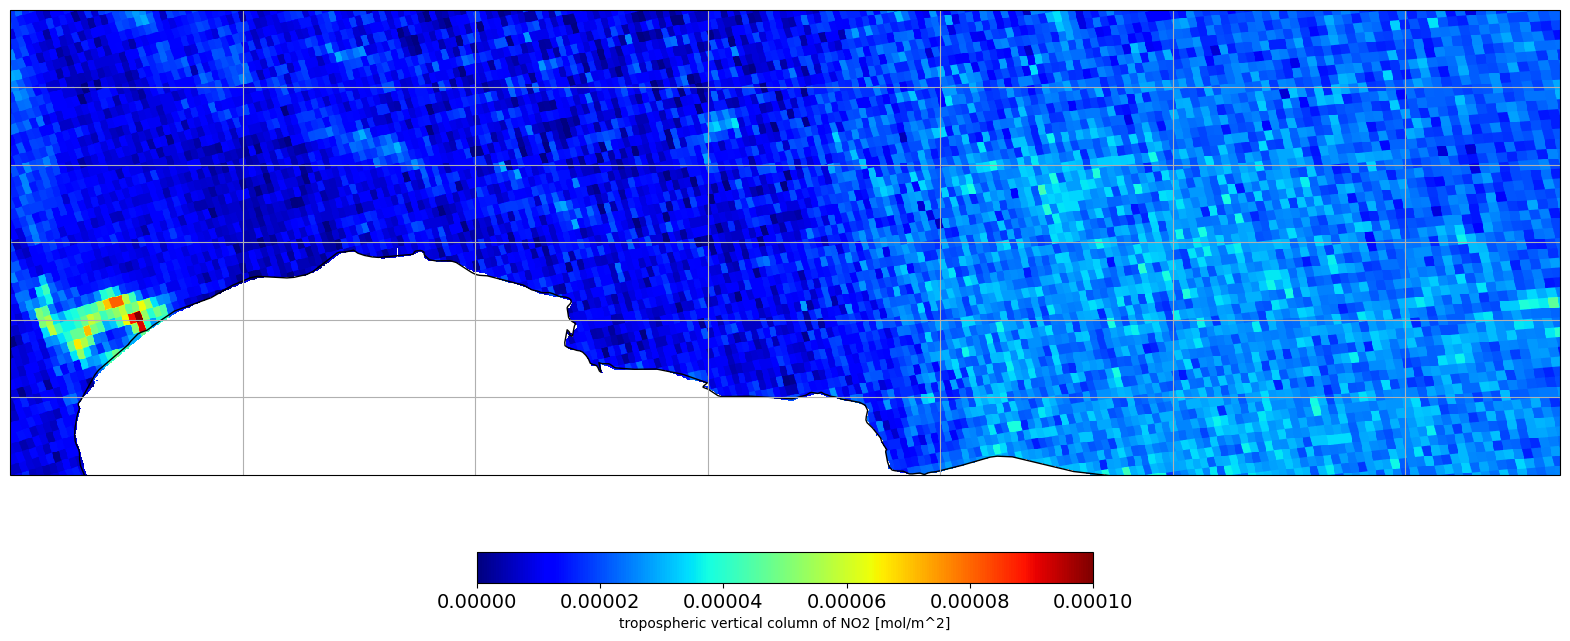

In [120]:
#plot the results of regridding and avereging
harp_l3meshplot(gridded, "tropospheric_NO2_column_number_density", colorrange=(0,0.0001))

In [121]:
#Export the results to netcdf
level3_filename = gridded.source_product
level3_filename = level3_filename.replace("_L2__", "_L3__")
print(f"Exporting to {level3_filename}")
harp.export_product(gridded, level3_filename)

Exporting to S5P_RPRO_L3__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc


CLibraryError: Permission denied (S5P_RPRO_L3__NO2____20190614T104316_20190614T122446_08641_03_020400_20221105T175851.nc)

In [ ]:
harp.import_product(level3_filename)

<Product variables=odict_keys(['datetime_start', 'datetime_length', 'tropospheric_NO2_column_number_density', 'datetime_stop', 'count', 'weight', 'latitude_bounds', 'longitude_bounds', 'latitude', 'longitude'])>